# Fake news Detection

In [2]:
# import libraries

import numpy as np
from time import time
import pandas as pd

import nltk

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score,recall_score, accuracy_score, make_scorer, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer, f1_score
from scipy.stats import wilcoxon


nltk.download('stopwords')
nltk.download('words')
# download stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Paola\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Paola\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Dataset

In [3]:
# reading dataset
df = pd.read_csv('./final_dataset.csv')
df

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS NATO allies on Tuesday welcomed Presi...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON LexisNexis, a provider of legal, regula...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK In the shadow of disused Soviet-era fact...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW Vatican Secretary of State Cardinal Pie...,worldnews,"August 22, 2017",0


In [4]:
# delete uneuseful columns from dataset
try:
    df['body'] = df['title'] + ' ' + df['text']
    df.drop('subject', axis=1, inplace=True)
    df.drop('date', axis=1, inplace=True)
    df.drop('title', axis=1, inplace=True)
    df.drop('text', axis=1, inplace=True)
except KeyError:
    print('already drop')

df

,fake,body
0,1,Donald Trump Sends Out Embarrassing New Year’...
1,1,Drunk Bragging Trump Staffer Started Russian ...
2,1,Sheriff David Clarke Becomes An Internet Joke...
3,1,Trump Is So Obsessed He Even Has Obama’s Name...
4,1,Pope Francis Just Called Out Donald Trump Dur...
...,...,...
44893,0,'Fully committed' NATO backs new U.S. approach...
44894,0,LexisNexis withdrew two products from Chinese ...
44895,0,Minsk cultural hub becomes haven from authorit...
44896,0,Vatican upbeat on possibility of Pope Francis ...


# Pre-processing
1. Remove duplicates
2. Tokenization
3. Feature selection: remove stopwords
4. Stemming

In [68]:
# count the number of fake and real news
df.fake.value_counts()

1    23481
0    21417
Name: fake, dtype: int64

We considered this dataset balanced

In [5]:
# removing possible duplicate news
df.drop_duplicates(inplace=True)
df.fake.value_counts()

0    21196
1    17908
Name: fake, dtype: int64

The dataset is still balanced after duplicates removal

## WordCloud

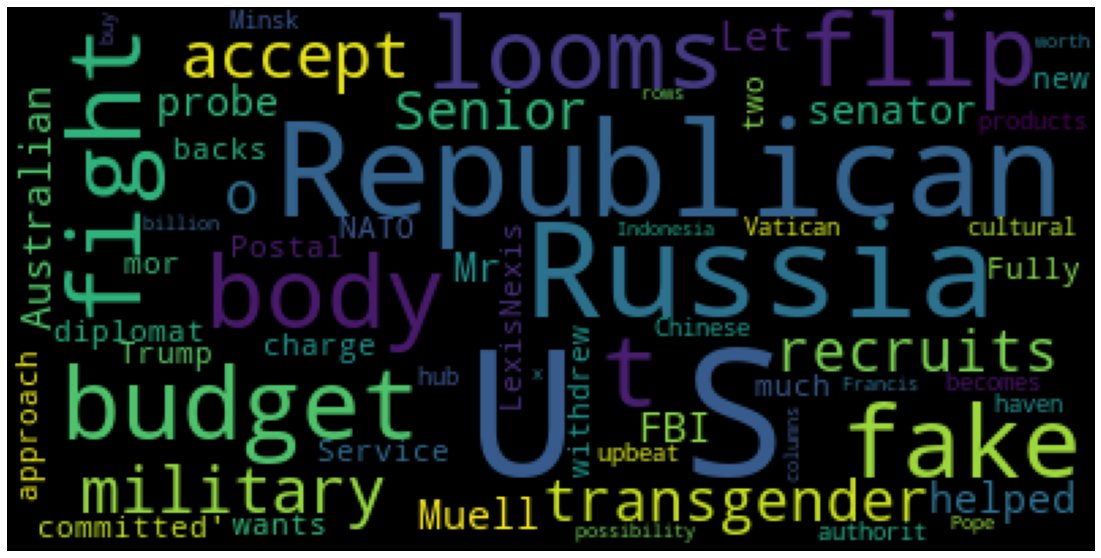

In [70]:
# WordCloud for fake news
wordcloud = WordCloud().generate(str(df[df.fake == 0]))
# Generate plot
plt.figure(figsize=[50,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

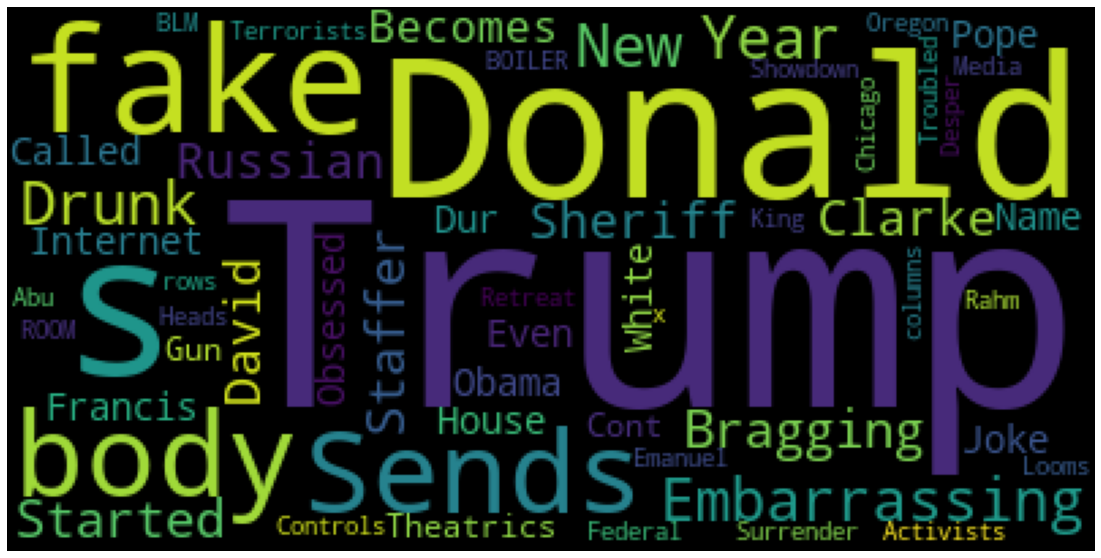

In [71]:
# WordCloud for t
wordcloud = WordCloud().generate(str(df[df.fake == 1]))
# Generate plot
plt.figure(figsize=[50,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [6]:
# Feature matrix and target vector
X = df['body'].values
y = df['fake'].values

# Splitting in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# transform train and test vector with CountVectorizer with default parameters
cv_vectorizer = CountVectorizer()
X_train_vector_cv = cv_vectorizer.fit_transform(X_train) # fit on training data, trasform training data
X_test_vector_cv = cv_vectorizer.transform(X_test) # transform test data

# transform train and test vector with TfidfVectorizer with default parameters
tfidf_vectorizer = TfidfVectorizer()
X_train_vector_tfidf = tfidf_vectorizer.fit_transform(X_train) # fit on training data, trasform training data
X_test_vector_tfidf = tfidf_vectorizer.transform(X_test) # transform test data

# stemmers
snow_stemmer = SnowballStemmer('english')
porter = PorterStemmer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def porter_analyzer_cv(doc):
    return [porter.stem(w) for w in analyzer_cv(doc)]

def porter_analyzer_tfidf(doc):
    return [porter.stem(w) for w in analyzer_tfidf(doc)]

def snowball_analyzer_cv(doc):
    return [snow_stemmer.stem(w) for w in analyzer_cv(doc)]
    
def snowball_analyzer_tfidf(doc):
    return [snow_stemmer.stem(w) for w in analyzer_tfidf(doc)]

def lemmatizer_analyzer_cv(doc):
    return [lemmatizer.lemmatize(w) for w in analyzer_cv(doc)]

def lemmatizer_analyzer_tfidf(doc):
    return [lemmatizer.lemmatize(w) for w in analyzer_tfidf(doc)]

# analyzer for CountVectorizer and TfidfVectorizer to be passed in the Pipeline

analyzer_cv = CountVectorizer(stop_words=stopwords).build_analyzer()

analyzer_tfidf = TfidfVectorizer(stop_words=stopwords).build_analyzer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Paola\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Paola\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Paola\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


In [73]:
# Training set after being processed with simple CountVectorizer.
X_train_vector_cv

<27372x102364 sparse matrix of type '<class 'numpy.int64'>'
	with 5740666 stored elements in Compressed Sparse Row format>

In [74]:
# Training set after being processed with stopwords removal and stemming.
cv_vectorizer_stem = CountVectorizer(analyzer = snowball_analyzer_cv)
X_train_vector_cv_stem = cv_vectorizer_stem.fit_transform(X_train)
X_train_vector_cv_stem

<27372x78717 sparse matrix of type '<class 'numpy.int64'>'
	with 4228683 stored elements in Compressed Sparse Row format>

In [75]:
# training set after being processed with simple TfidfVectorizer.
X_train_vector_tfidf

<27372x102364 sparse matrix of type '<class 'numpy.float64'>'
	with 5740666 stored elements in Compressed Sparse Row format>

In [76]:
# Training set after being processed with stopwords removal and stemming.
tf_vectorizer_stem = TfidfVectorizer(analyzer = snowball_analyzer_cv)
X_train_vector_tf_stem = tf_vectorizer_stem.fit_transform(X_train)
X_train_vector_tf_stem

<27372x78717 sparse matrix of type '<class 'numpy.float64'>'
	with 4228683 stored elements in Compressed Sparse Row format>

### Example of text pre processing 
#### Uncleaned text
The striped bats are hanging on their feet for best

#### Stopwords removal
['striped', 'bats', 'hanging', 'feet', 'best']

#### Snowball Stemming

In [10]:
print(snowball_analyzer_cv("The striped bats are hanging on their feet for best"))

['stripe', 'bat', 'hang', 'feet', 'best']


#### Porter Stemming

In [78]:
print(porter_analyzer_cv("The striped bats are hanging on their feet for best"))

['stripe', 'bat', 'hang', 'feet', 'best']


#### Lemmatizer

In [79]:
print(lemmatizer_analyzer_cv("The striped bats are hanging on their feet for best"))

['striped', 'bat', 'hanging', 'foot', 'best']


# Simple hold out validation with four classifiers

Now we start the simple hold out validation with four classifiers, using for each one the CountVectorizer and TfidfVectorizer combined with Snowball Stemming or default parameters.

Part of this section is the trial with the reduced features (max_features=40000) in the CountVectorizer with Snowball Stemming and stopwords removal.

# Multinomial NB

### Multinomial NB with CountVectorizer (default)

              precision    recall  f1-score   support

   True news       0.96      0.95      0.95      6286
   Fake news       0.94      0.95      0.95      5446

    accuracy                           0.95     11732
   macro avg       0.95      0.95      0.95     11732
weighted avg       0.95      0.95      0.95     11732

Classification accuracy 94.9%


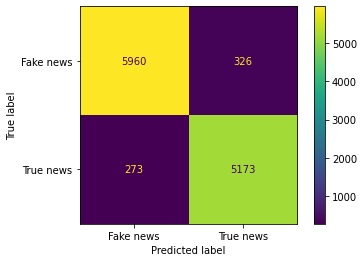

In [80]:
mnb_cv = MultinomialNB()
mnb_cv.fit(X_train_vector_cv, y_train)
y_pred = mnb_cv.predict(X_test_vector_cv)

mnb_cv_acc = accuracy_score(y_test, y_pred)
# Print results
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### Multinomial NB with CountVectorizer (Snowball Stemming)

              precision    recall  f1-score   support

   True news       0.96      0.94      0.95      6286
   Fake news       0.93      0.95      0.94      5446

    accuracy                           0.94     11732
   macro avg       0.94      0.94      0.94     11732
weighted avg       0.94      0.94      0.94     11732

Classification accuracy 94.4%


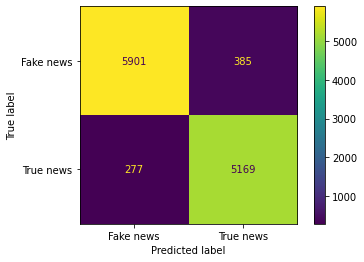

In [81]:
estimators = [('cv', CountVectorizer(analyzer=snowball_analyzer_cv)), ('clf', MultinomialNB())]

mnb_cv_stem = Pipeline(estimators)
mnb_cv_stem.fit(X_train, y_train)
y_pred = mnb_cv_stem.predict(X_test)
mnb_stem_acc = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### Multinomial NB with TfidfVectorizer (default)

              precision    recall  f1-score   support

   True news       0.92      0.96      0.94      6286
   Fake news       0.96      0.90      0.93      5446

    accuracy                           0.94     11732
   macro avg       0.94      0.93      0.94     11732
weighted avg       0.94      0.94      0.94     11732

Classification accuracy 93.7%


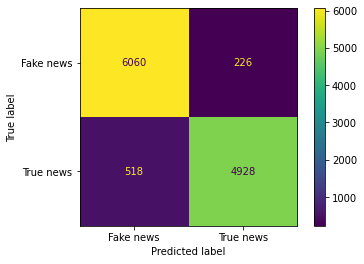

In [82]:
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(X_train_vector_tfidf, y_train)
y_pred = mnb_tfidf.predict(X_test_vector_tfidf)

mnb_tfidf_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()


### Multinomial NB with TfidfVectorizer (Snowball Stemming)

              precision    recall  f1-score   support

   True news       0.92      0.96      0.94      6286
   Fake news       0.95      0.90      0.93      5446

    accuracy                           0.93     11732
   macro avg       0.94      0.93      0.93     11732
weighted avg       0.93      0.93      0.93     11732

Classification accuracy 93.4%


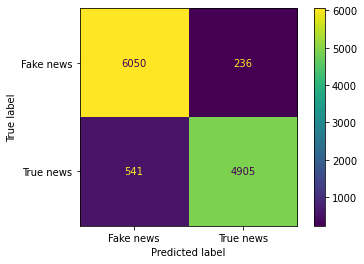

In [83]:
estimators = [('cv', TfidfVectorizer(analyzer=snowball_analyzer_tfidf)), ('clf', MultinomialNB())]

mnb_tfidf_stem = Pipeline(estimators)
mnb_tfidf_stem.fit(X_train, y_train)
y_pred = mnb_tfidf_stem.predict(X_test)
mnb_tfidf_stem_acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### CountVectorizer (Snowball Stemming and max_features=40000)

              precision    recall  f1-score   support

   True news       0.96      0.94      0.95      6286
   Fake news       0.93      0.95      0.94      5446

    accuracy                           0.94     11732
   macro avg       0.94      0.94      0.94     11732
weighted avg       0.94      0.94      0.94     11732

Classification accuracy 94.3%


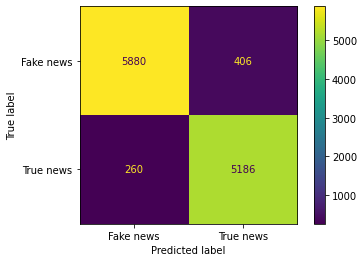

In [161]:
estimators = [('cv', CountVectorizer(analyzer=snowball_analyzer_cv, max_features=40000)), ('clf', MultinomialNB())]

mnb_cv_stem_red = Pipeline(estimators)
mnb_cv_stem_red.fit(X_train, y_train)
y_pred = mnb_cv_stem_red.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

## Comparison

In [84]:
nb_accuracy = pd.DataFrame([{
    'CountVectorizer (default)': mnb_cv_acc*100,
    'CountVectorizer (Snowball Stemming)': mnb_stem_acc*100,
    'TfidfVectorizer (default)': mnb_tfidf_acc*100,
    'TfidfVectorizer (Snowball Stemming)': mnb_tfidf_stem_acc*100 
}])

array([[<AxesSubplot:title={'center':'CountVectorizer (default)'}>,
        <AxesSubplot:title={'center':'CountVectorizer (Snowball Stemming)'}>,
        <AxesSubplot:title={'center':'TfidfVectorizer (default)'}>,
        <AxesSubplot:title={'center':'TfidfVectorizer (Snowball Stemming)'}>]],
      dtype=object)

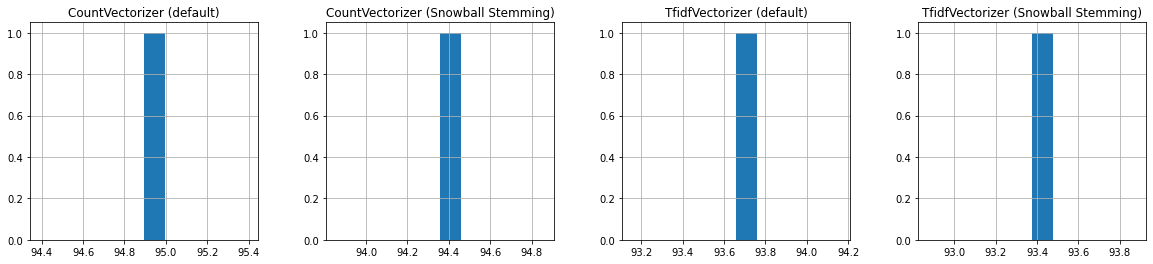

In [85]:
nb_accuracy.hist(layout=(1, 4), figsize=(20, 4))

<AxesSubplot:>

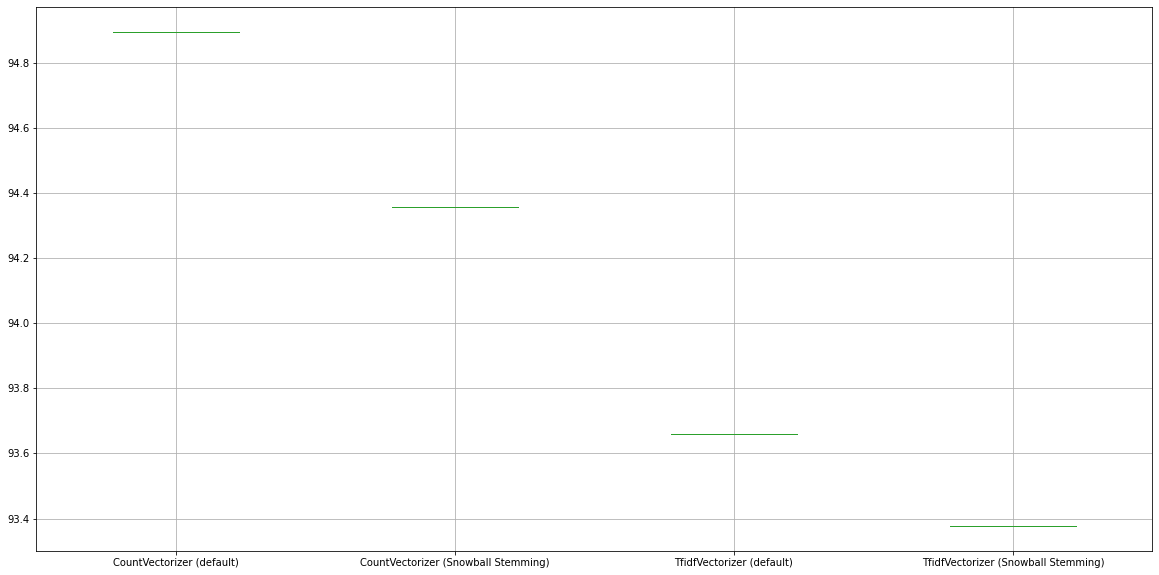

In [86]:
nb_accuracy.boxplot(figsize=[20,10])

### Accuracy mean:

In [87]:
print(nb_accuracy.values.mean())

94.07176951926355


# Support Vector (Linear SVC)

### Linear SVC with CountVectorizer (default)

              precision    recall  f1-score   support

   True news       0.98      0.99      0.98      6286
   Fake news       0.98      0.98      0.98      5446

    accuracy                           0.98     11732
   macro avg       0.98      0.98      0.98     11732
weighted avg       0.98      0.98      0.98     11732

Classification accuracy 98.2%


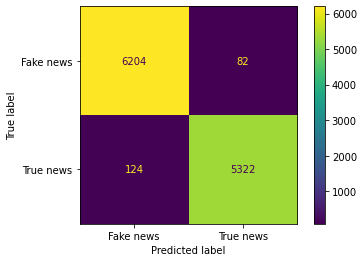

In [88]:
SVC_cv = LinearSVC(max_iter=100000)
SVC_cv.fit(X_train_vector_cv, y_train)
y_pred = SVC_cv.predict(X_test_vector_cv)

SVC_cv_acc = accuracy_score(y_test, y_pred)
# Print results
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### Linear SVC with CountVectorizer (Snowball Stemming)

              precision    recall  f1-score   support

   True news       0.98      0.98      0.98      6286
   Fake news       0.98      0.97      0.98      5446

    accuracy                           0.98     11732
   macro avg       0.98      0.98      0.98     11732
weighted avg       0.98      0.98      0.98     11732

Classification accuracy 97.9%


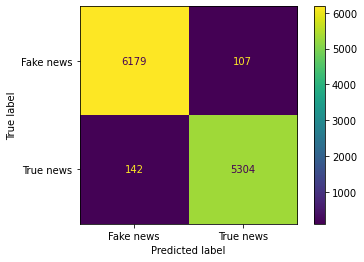

In [89]:
estimators = [('cv', CountVectorizer(analyzer=snowball_analyzer_cv)), ('clf', LinearSVC(max_iter=100000))]

svc_cv_stem = Pipeline(estimators)
svc_cv_stem.fit(X_train, y_train)
y_pred = svc_cv_stem.predict(X_test)
SVC_cv_stem_acc = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### Linear SVC with TfidfVectorizer (default)

              precision    recall  f1-score   support

   True news       0.99      0.99      0.99      6286
   Fake news       0.99      0.99      0.99      5446

    accuracy                           0.99     11732
   macro avg       0.99      0.99      0.99     11732
weighted avg       0.99      0.99      0.99     11732

Classification accuracy 99.0%


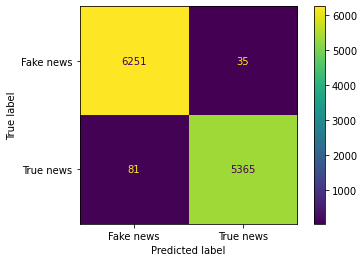

In [90]:
SVC_tfidf = LinearSVC()
SVC_tfidf.fit(X_train_vector_tfidf, y_train)
y_pred = SVC_tfidf.predict(X_test_vector_tfidf)
SVC_tfidf_acc = accuracy_score(y_test, y_pred)
# Print results
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### LinearSVC with TfidfVectorizer (Snowball Stemming)

              precision    recall  f1-score   support

   True news       0.99      0.99      0.99      6286
   Fake news       0.99      0.98      0.99      5446

    accuracy                           0.99     11732
   macro avg       0.99      0.99      0.99     11732
weighted avg       0.99      0.99      0.99     11732

Classification accuracy 98.8%


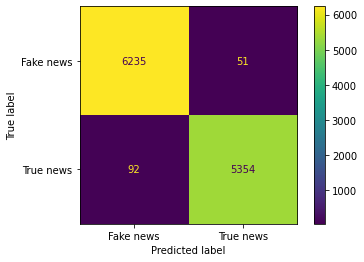

In [91]:
estimators = [('cv', TfidfVectorizer(analyzer=snowball_analyzer_tfidf)), ('clf', LinearSVC())]

svc_tfidf_stem = Pipeline(estimators)
svc_tfidf_stem.fit(X_train, y_train)
y_pred = svc_tfidf_stem.predict(X_test)
SVC_tfidf_stem_acc = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### CountVectorizer (Snowball Stemming and max_features=40000)

              precision    recall  f1-score   support

   True news       0.98      0.98      0.98      6286
   Fake news       0.98      0.97      0.98      5446

    accuracy                           0.98     11732
   macro avg       0.98      0.98      0.98     11732
weighted avg       0.98      0.98      0.98     11732

Classification accuracy 97.9%


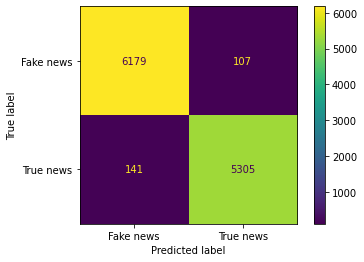

In [163]:
estimators = [('cv', CountVectorizer(analyzer=snowball_analyzer_cv, max_features=40000)), ('clf', LinearSVC(max_iter=100000))]

svc_cv_stem_red = Pipeline(estimators)
svc_cv_stem_red.fit(X_train, y_train)
y_pred = svc_cv_stem_red.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

## Comparison

In [92]:
sv_accuracy = pd.DataFrame([{
    'CountVectorizer (default)': SVC_cv_acc*100,
    'CountVectorizer (Snowball Stemming)': SVC_cv_stem_acc*100,
    'TfidfVectorizer (default)': SVC_tfidf_acc*100,
    'TfidfVectorizer (Snowball Stemming)': SVC_tfidf_stem_acc*100 
}])

array([[<AxesSubplot:title={'center':'CountVectorizer (default)'}>,
        <AxesSubplot:title={'center':'CountVectorizer (Snowball Stemming)'}>,
        <AxesSubplot:title={'center':'TfidfVectorizer (default)'}>,
        <AxesSubplot:title={'center':'TfidfVectorizer (Snowball Stemming)'}>]],
      dtype=object)

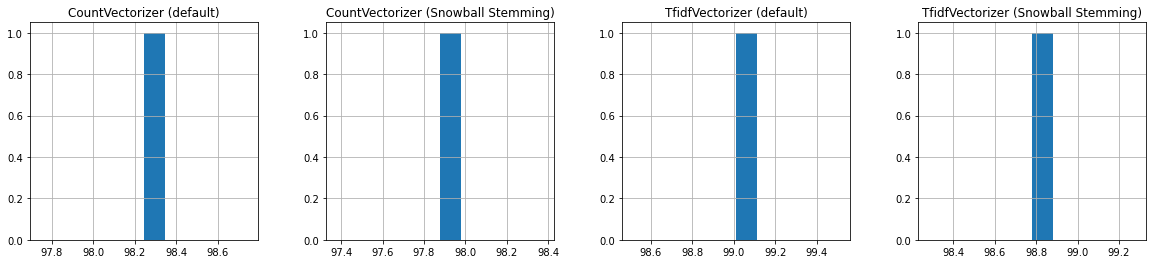

In [93]:
sv_accuracy.hist(layout=(1, 4), figsize=(20, 4))

<AxesSubplot:>

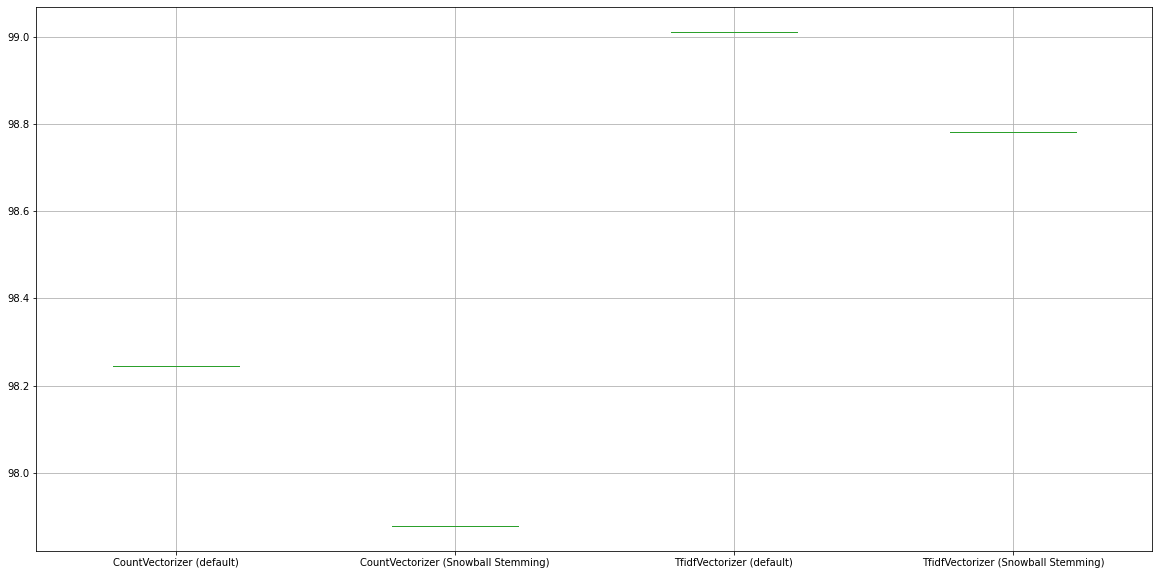

In [94]:
sv_accuracy.boxplot(figsize=[20,10])

### Accuracy mean:

In [95]:
print(sv_accuracy.values.mean())

98.47852028639619


# Logistic Regression

### LogisticRegression with CountVectorizer (default)

              precision    recall  f1-score   support

   True news       0.98      0.99      0.99      6286
   Fake news       0.99      0.98      0.99      5446

    accuracy                           0.99     11732
   macro avg       0.99      0.99      0.99     11732
weighted avg       0.99      0.99      0.99     11732

Classification accuracy 98.6%


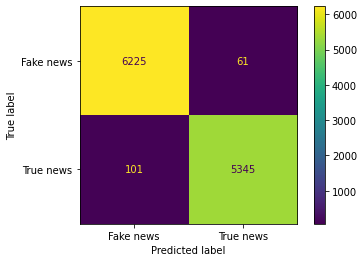

In [96]:
LR_cv = LogisticRegression(max_iter=100000)
LR_cv.fit(X_train_vector_cv, y_train)
y_pred = LR_cv.predict(X_test_vector_cv)

LR_cv_acc = accuracy_score(y_test, y_pred)
# Print results
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### LogisticRegression with CountVectorizer (Snowball Stemming)

              precision    recall  f1-score   support

   True news       0.98      0.99      0.98      6286
   Fake news       0.99      0.98      0.98      5446

    accuracy                           0.98     11732
   macro avg       0.98      0.98      0.98     11732
weighted avg       0.98      0.98      0.98     11732

Classification accuracy 98.3%


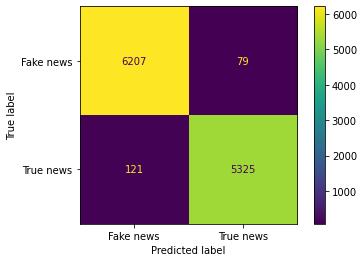

In [97]:
estimators = [('cv', CountVectorizer(analyzer=snowball_analyzer_cv)), ('clf', LogisticRegression(max_iter=100000))]

lr_cv_stem = Pipeline(estimators)
lr_cv_stem.fit(X_train, y_train)
y_pred = lr_cv_stem.predict(X_test)
LR_cv_stem_acc = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))

print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### LogisticRegression with TfidfVectorizer (default)

              precision    recall  f1-score   support

   True news       0.98      0.99      0.98      6286
   Fake news       0.99      0.98      0.98      5446

    accuracy                           0.98     11732
   macro avg       0.98      0.98      0.98     11732
weighted avg       0.98      0.98      0.98     11732

Classification accuracy 98.3%


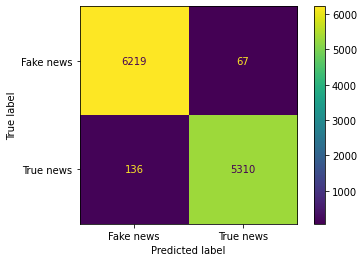

In [98]:
LR_tfidf = LogisticRegression()
LR_tfidf.fit(X_train_vector_tfidf, y_train)
y_pred = LR_tfidf.predict(X_test_vector_tfidf)
LR_tfidf_acc = accuracy_score(y_test, y_pred) 
# Print results
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### LogisticRegression with TfidfVectorizer (Snowball Stemming)

              precision    recall  f1-score   support

   True news       0.98      0.99      0.98      6286
   Fake news       0.98      0.97      0.98      5446

    accuracy                           0.98     11732
   macro avg       0.98      0.98      0.98     11732
weighted avg       0.98      0.98      0.98     11732

Classification accuracy 98.1%


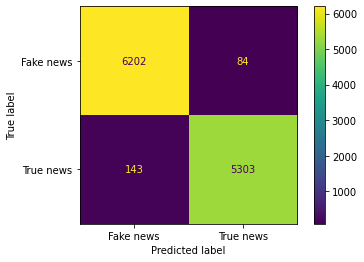

In [99]:
estimators = [('cv', TfidfVectorizer(analyzer=snowball_analyzer_tfidf)), ('clf', LogisticRegression())]

lr_tfidf_stem = Pipeline(estimators)
lr_tfidf_stem.fit(X_train, y_train)
y_pred = lr_tfidf_stem.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
LR_tfidf_stem_acc = accuracy_score(y_pred, y_test)
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### CountVectorizer (Snowball Stemming and max_features=40000)

              precision    recall  f1-score   support

   True news       0.98      0.99      0.98      6286
   Fake news       0.99      0.98      0.98      5446

    accuracy                           0.98     11732
   macro avg       0.98      0.98      0.98     11732
weighted avg       0.98      0.98      0.98     11732

Classification accuracy 98.3%


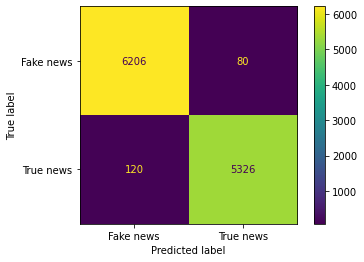

In [164]:
estimators = [('cv', CountVectorizer(analyzer=snowball_analyzer_cv, max_features=40000)), ('clf', LogisticRegression(max_iter=100000))]

lr_cv_stem_red = Pipeline(estimators)
lr_cv_stem_red.fit(X_train, y_train)
y_pred = lr_cv_stem_red.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))

print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

## Comparison

In [100]:
lr_accuracy = pd.DataFrame([{
    'CountVectorizer (default)': LR_cv_acc*100,
    'CountVectorizer (Snowball Stemming)': LR_cv_stem_acc*100,
    'TfidfVectorizer (default)': LR_tfidf_acc*100,
    'TfidfVectorizer (Snowball Stemming)': LR_tfidf_stem_acc*100 
}])

array([[<AxesSubplot:title={'center':'CountVectorizer (default)'}>,
        <AxesSubplot:title={'center':'CountVectorizer (Snowball Stemming)'}>,
        <AxesSubplot:title={'center':'TfidfVectorizer (default)'}>,
        <AxesSubplot:title={'center':'TfidfVectorizer (Snowball Stemming)'}>]],
      dtype=object)

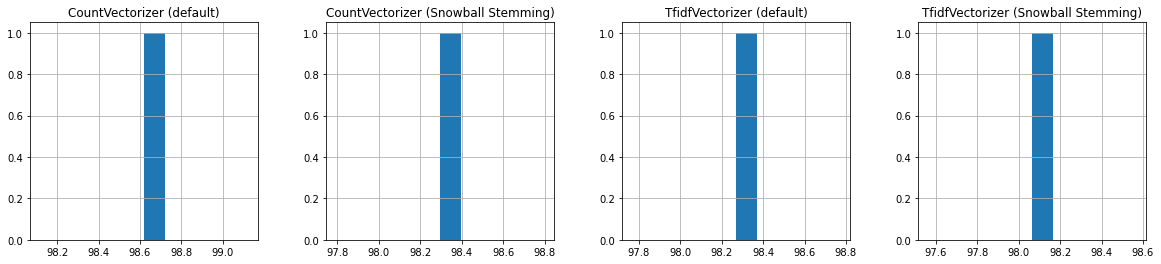

In [101]:
lr_accuracy.hist(layout=(1, 4), figsize=(20, 4))

<AxesSubplot:>

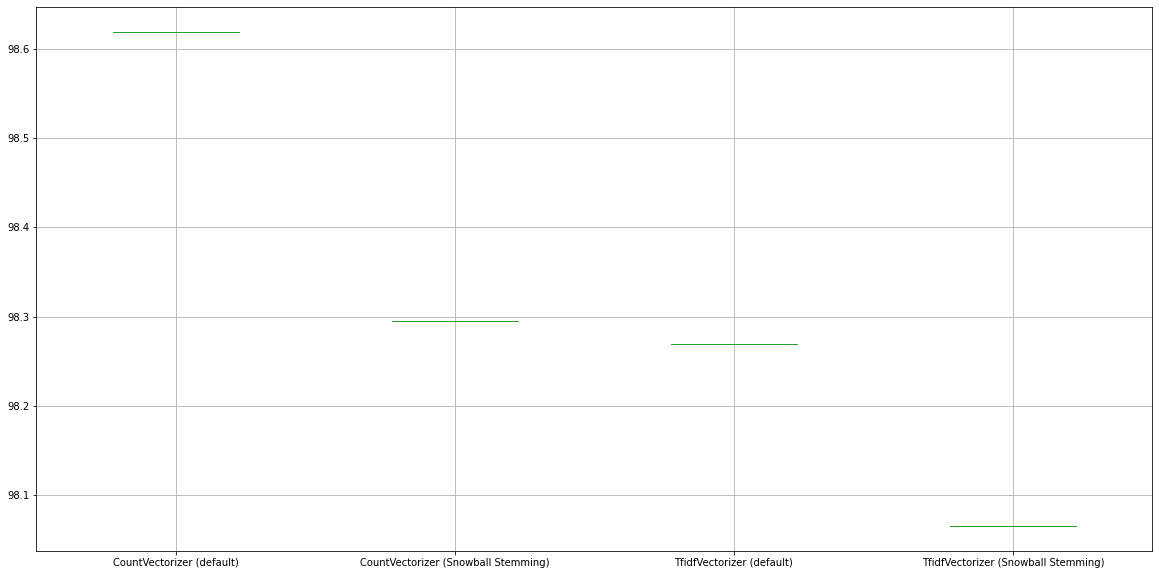

In [102]:
lr_accuracy.boxplot(figsize=[20,10])

### Accuracy mean:

In [103]:
print(lr_accuracy.values.mean())

98.31230821684282


# Decision Tree

We exploit the Decision Tree representation to analyze deeper how the classifier works with respect to the words chosen for the splitting. For this purpose, in this section there won't be only the four trials as the previous sections, but we added two other stemming algorithm: Porter stemming (less aggressive) and Lemmatizer.

### Decision Tree with CountVectorizer (default)

              precision    recall  f1-score   support

   True news       0.95      0.95      0.95      6286
   Fake news       0.95      0.94      0.95      5446

    accuracy                           0.95     11732
   macro avg       0.95      0.95      0.95     11732
weighted avg       0.95      0.95      0.95     11732

Classification accuracy 95.0%


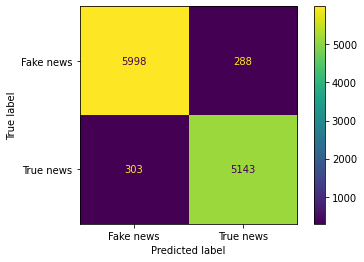

In [104]:
DT_cv = DecisionTreeClassifier()
DT_cv.fit(X_train_vector_cv, y_train)
y_pred = DT_cv.predict(X_test_vector_cv)

DT_cv_acc = accuracy_score(y_test, y_pred)
# Print results
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

#### Tree plot

We build a list of strings (words), ordered in the same way as they are in the dictionary created from CountVectorizer (cv_vectorizer.vocabulary_), to be passed as feature_names parameter in the tree plot.

We also set max_depth = 2 to better see the tree nodes.

Tree depth:
150


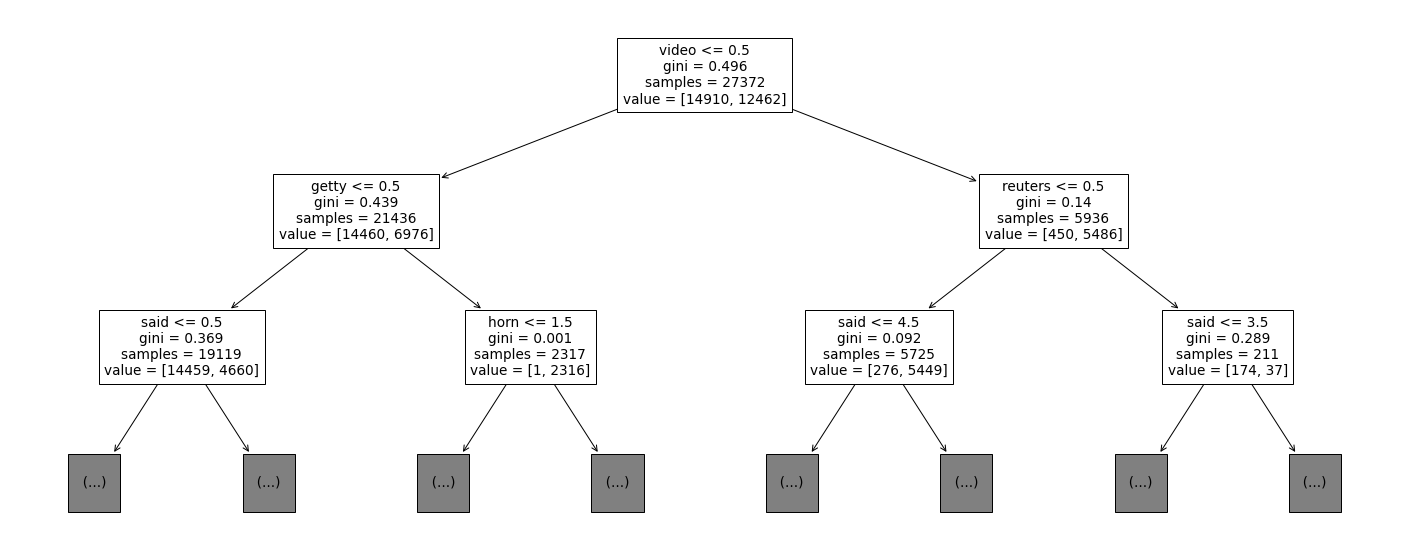

In [105]:
l = [0 for i in range (0,len(cv_vectorizer.vocabulary_.items()))]
for (k, val) in (cv_vectorizer.vocabulary_.items()):
    l[val] = k
# plot the tree 
print("Tree depth:")
print(DT_cv.get_depth())
plt.figure(figsize=[25,10])
plot_tree(DT_cv, max_depth=2, feature_names=l)
plt.show()

### Decision Tree with CountVectorizer (Snowball Stemming)

In [106]:
estimators = [('cv', CountVectorizer(analyzer=snowball_analyzer_cv)), ('clf', DecisionTreeClassifier())]

DT_cv_snowstem = Pipeline(estimators)
DT_cv_snowstem.fit(X_train, y_train)
y_pred = DT_cv_snowstem.predict(X_test)
DT_cv_snow_acc = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))

print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))


              precision    recall  f1-score   support

   True news       0.95      0.95      0.95      6286
   Fake news       0.94      0.94      0.94      5446

    accuracy                           0.95     11732
   macro avg       0.95      0.95      0.95     11732
weighted avg       0.95      0.95      0.95     11732

Classification accuracy 94.6%


#### Tree plot

We build a list of strings (words), ordered in the same way as they are in the dictionary created from CountVectorizer with stemming (pipe[0].vocabulary_), to be passed as feature_names parameter in the tree plot.

We also set max_depth = 2 to better see the tree nodes.

157


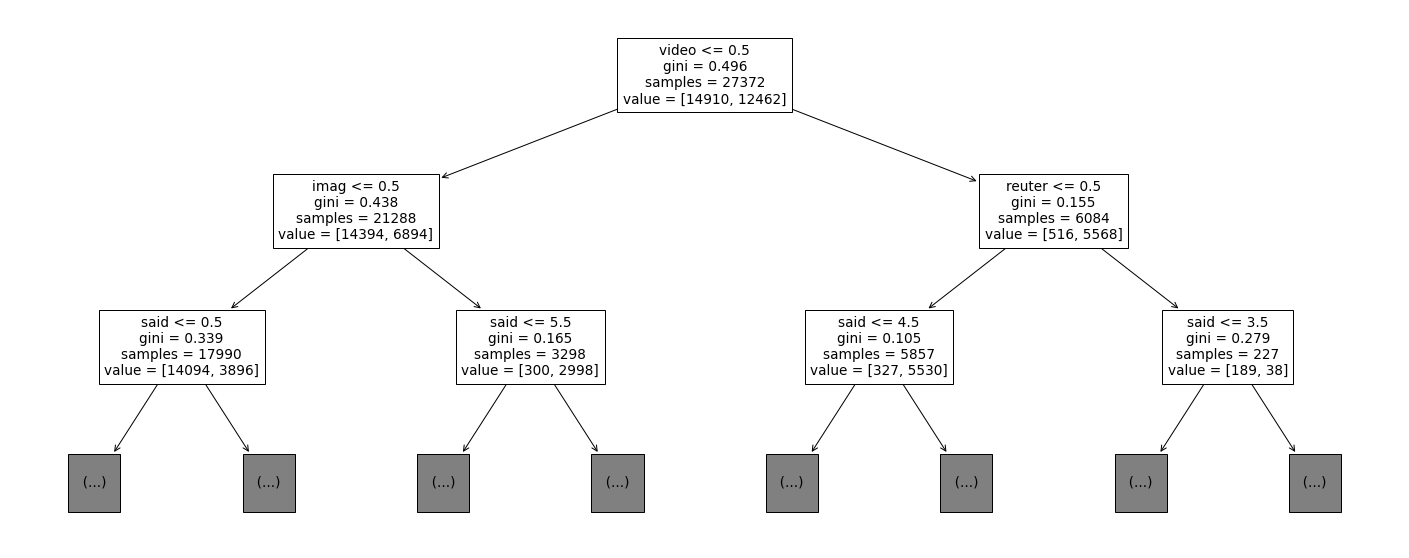

In [107]:
l_snow = [0 for i in range (0,len(DT_cv_snowstem[0].vocabulary_.items()))]
for (k, val) in (DT_cv_snowstem[0].vocabulary_.items()):
    l_snow[val] = k
# plot the tree
print(DT_cv_snowstem[1].get_depth())
plt.figure(figsize=[25,10])
plot_tree(DT_cv_snowstem[1], max_depth=2, feature_names=l_snow)
plt.show()


### Decision Tree with CountVectorizer (Porter Stemming) 

              precision    recall  f1-score   support

   True news       0.95      0.95      0.95      6286
   Fake news       0.94      0.94      0.94      5446

    accuracy                           0.95     11732
   macro avg       0.95      0.95      0.95     11732
weighted avg       0.95      0.95      0.95     11732

Classification accuracy 94.6%


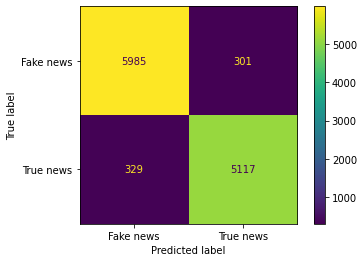

In [108]:
estimators = [('cv', CountVectorizer(analyzer=porter_analyzer_cv)), ('clf', DecisionTreeClassifier())]

DT_cv_porterstem = Pipeline(estimators)
DT_cv_porterstem.fit(X_train, y_train)
y_pred = DT_cv_porterstem.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
DT_cv_porter_acc = accuracy_score(y_pred, y_test)
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

#### Tree plot

We build a list of strings (words), ordered in the same way as they are in the dictionary created from CountVectorizer (pipe[0].vocabulary_), to be passed as feature_names parameter in the tree plot.

We also set max_depth = 2 to better see the tree nodes.

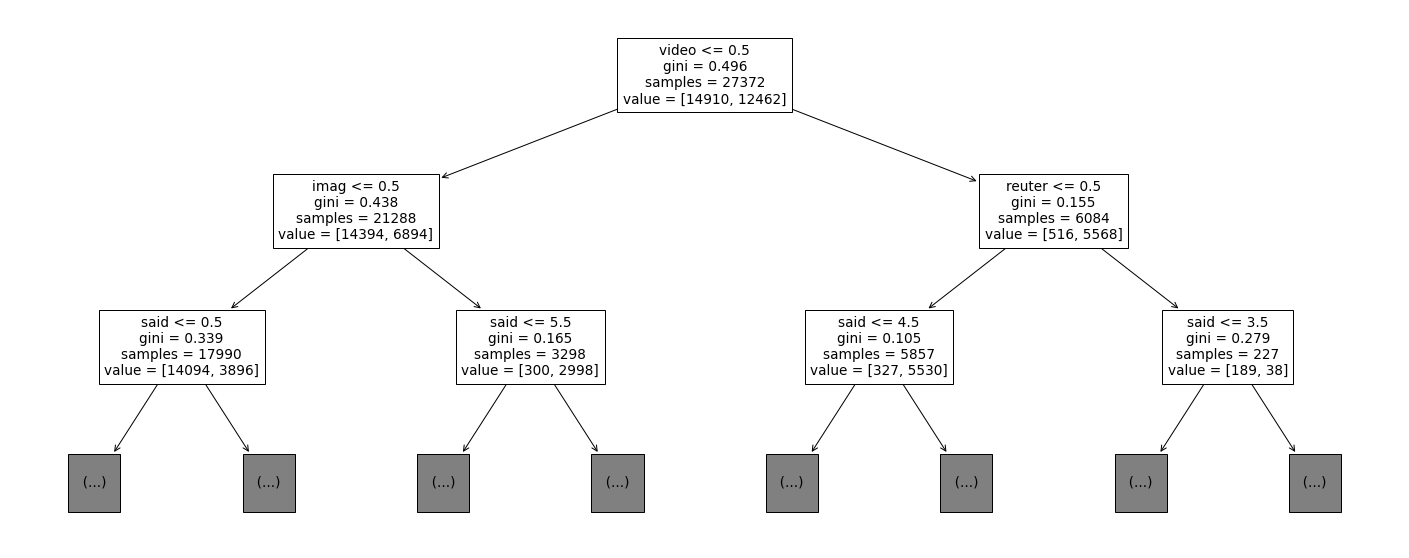

In [109]:
l_porter = [0 for i in range (0,len(DT_cv_porterstem[0].vocabulary_.items()))]
for (k, val) in (DT_cv_porterstem[0].vocabulary_.items()):
    l_porter[val] = k
# plot the tree
plt.figure(figsize=[25,10])
plot_tree(DT_cv_porterstem[1], max_depth=2, feature_names=l_porter)
plt.show()

### Decision Tree with CountVectorizer (Lemmatizer) 

              precision    recall  f1-score   support

   True news       0.95      0.95      0.95      6286
   Fake news       0.95      0.94      0.95      5446

    accuracy                           0.95     11732
   macro avg       0.95      0.95      0.95     11732
weighted avg       0.95      0.95      0.95     11732

Classification accuracy 95.0%


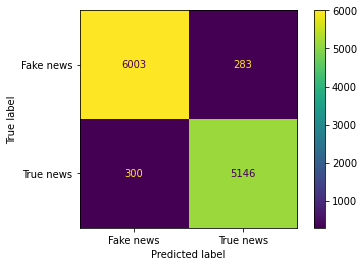

In [110]:
estimators = [('cv', CountVectorizer(analyzer=lemmatizer_analyzer_cv)), ('clf', DecisionTreeClassifier())]

DT_cv_lemmatizer = Pipeline(estimators)
DT_cv_lemmatizer.fit(X_train, y_train)
y_pred = DT_cv_lemmatizer.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
DT_cv_lemm_acc = accuracy_score(y_pred, y_test)
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

#### Tree plot

We build a list of strings (words), ordered in the same way as they are in the dictionary created from CountVectorizer (pipe[0].vocabulary_), to be passed as feature_names parameter in the tree plot.

We also set max_depth = 2 to better see the tree nodes.

144


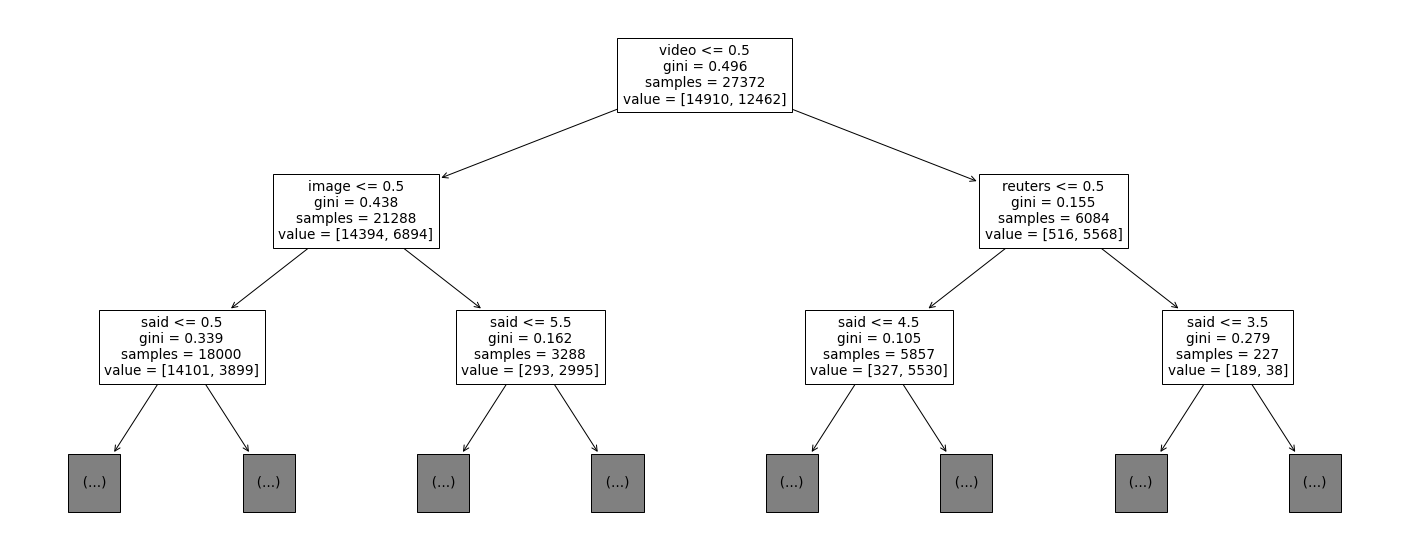

In [111]:
l_lemm = [0 for i in range (0,len(DT_cv_lemmatizer[0].vocabulary_.items()))]
for (k, val) in (DT_cv_lemmatizer[0].vocabulary_.items()):
    l_lemm[val] = k
    
# plot the tree
print(DT_cv_lemmatizer[1].get_depth())
plt.figure(figsize=[25,10])
plot_tree(DT_cv_lemmatizer[1], max_depth=2, feature_names=l_lemm)
plt.show()

### Decision Tree with TfidfVectorizer (default)

              precision    recall  f1-score   support

   True news       0.95      0.95      0.95      6286
   Fake news       0.94      0.94      0.94      5446

    accuracy                           0.94     11732
   macro avg       0.94      0.94      0.94     11732
weighted avg       0.94      0.94      0.94     11732

Classification accuracy 94.4%


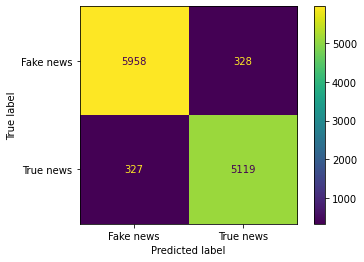

In [112]:
DT_tfidf = DecisionTreeClassifier()
DT_tfidf.fit(X_train_vector_tfidf, y_train)
y_pred = DT_tfidf.predict(X_test_vector_tfidf)

DT_tfidf_acc = accuracy_score(y_test, y_pred)
# Print results
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### Decision Tree with TfidfVectorizer (Snowball Stemming)

              precision    recall  f1-score   support

   True news       0.95      0.95      0.95      6286
   Fake news       0.94      0.94      0.94      5446

    accuracy                           0.95     11732
   macro avg       0.95      0.95      0.95     11732
weighted avg       0.95      0.95      0.95     11732

Classification accuracy 94.8%


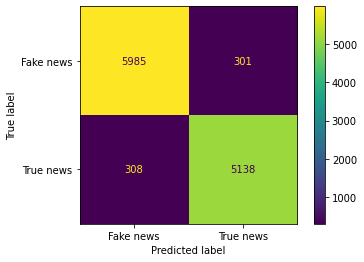

In [113]:
estimators = [('cv', TfidfVectorizer(analyzer=snowball_analyzer_tfidf)), ('clf', DecisionTreeClassifier())]

DT_tfidf_stem = Pipeline(estimators)
DT_tfidf_stem.fit(X_train, y_train)
y_pred = DT_tfidf_stem.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))

DT_tfidf_stem = accuracy_score(y_pred, y_test)
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

### CountVectorizer (Snowball Stemming and max_features=40000)

In [7]:
estimators = [('cv', CountVectorizer(analyzer=snowball_analyzer_cv, max_features=40000)), ('clf', DecisionTreeClassifier())]

DT_cv_snowstem_red = Pipeline(estimators)
DT_cv_snowstem_red.fit(X_train, y_train)
y_pred = DT_cv_snowstem_red.predict(X_test)
DT_cv_snow_acc = accuracy_score(y_pred, y_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))

print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

   True news       0.95      0.95      0.95      6317
   Fake news       0.95      0.94      0.94      5415

    accuracy                           0.95     11732
   macro avg       0.95      0.94      0.95     11732
weighted avg       0.95      0.95      0.95     11732

Classification accuracy 94.6%


#### Tree plot

We build a list of strings (words), ordered in the same way as they are in the dictionary created from CountVectorizer (pipe[0].vocabulary_) with features number reduced, to be passed as feature_names parameter in the tree plot.

We also set max_depth = 2 to better see the tree nodes.

171


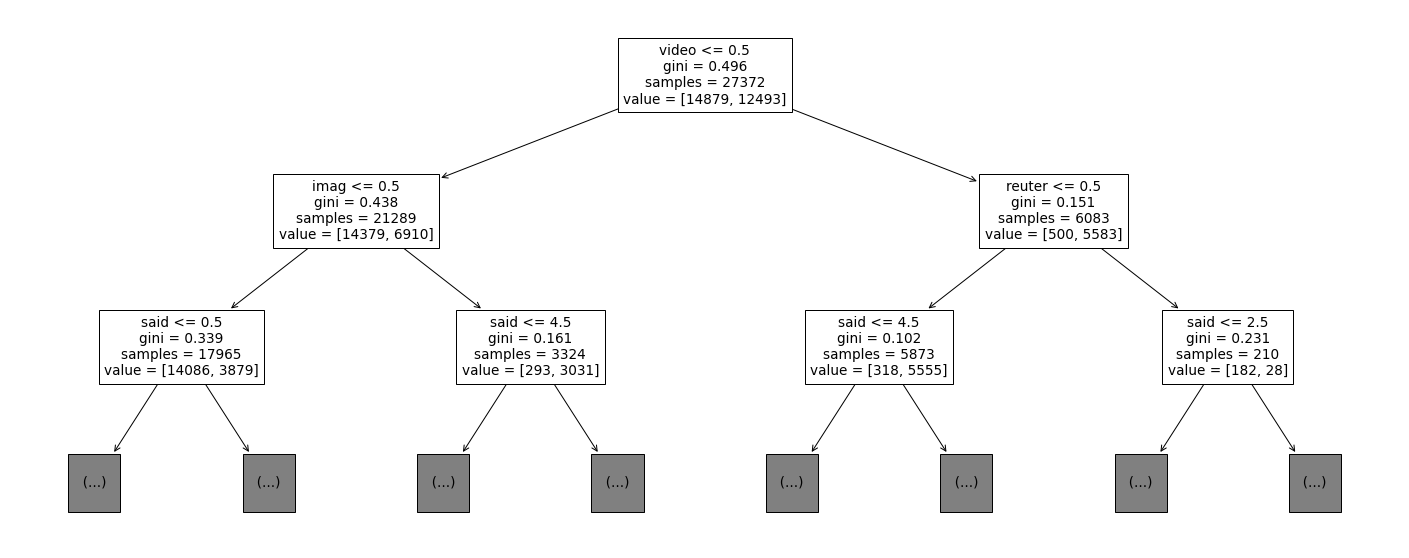

In [9]:
l_red = [0 for i in range (0,len(DT_cv_snowstem_red[0].vocabulary_.items()))]
for (k, val) in (DT_cv_snowstem_red[0].vocabulary_.items()):
    l_red[val] = k
    
# plot the tree
print(DT_cv_snowstem_red[1].get_depth())
plt.figure(figsize=[25,10])
plot_tree(DT_cv_snowstem_red[1], max_depth=2, feature_names=l_red)
plt.show()

## Comparison

In [114]:
dt_accuracy = pd.DataFrame([{
    'CountVectorizer (default)': DT_cv_acc*100,
    'CountVectorizer (Snowball Stemming)': DT_cv_snow_acc*100,
    'CountVectorizer (Porter Stemming)': DT_cv_porter_acc*100,
    'CountVectorizer (Lemmatizer)': DT_cv_lemm_acc*100,
    'TfidfVectorizer (default)': DT_tfidf_acc*100,
    'TfidfVectorizer (SnowBall Stemming)': DT_tfidf_stem*100 
}])

array([[<AxesSubplot:title={'center':'CountVectorizer (default)'}>,
        <AxesSubplot:title={'center':'CountVectorizer (Snowball Stemming)'}>,
        <AxesSubplot:title={'center':'CountVectorizer (Porter Stemming)'}>,
        <AxesSubplot:title={'center':'CountVectorizer (Lemmatizer)'}>,
        <AxesSubplot:title={'center':'TfidfVectorizer (default)'}>,
        <AxesSubplot:title={'center':'TfidfVectorizer (SnowBall Stemming)'}>]],
      dtype=object)

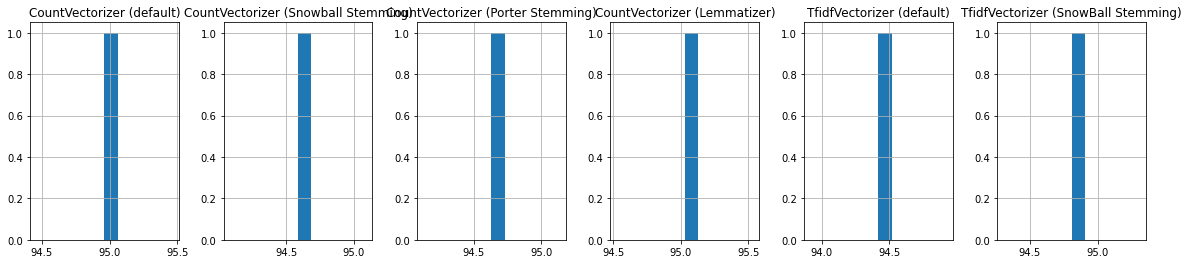

In [115]:
dt_accuracy.hist(layout=(1, 6), figsize=(20, 4))

<AxesSubplot:>

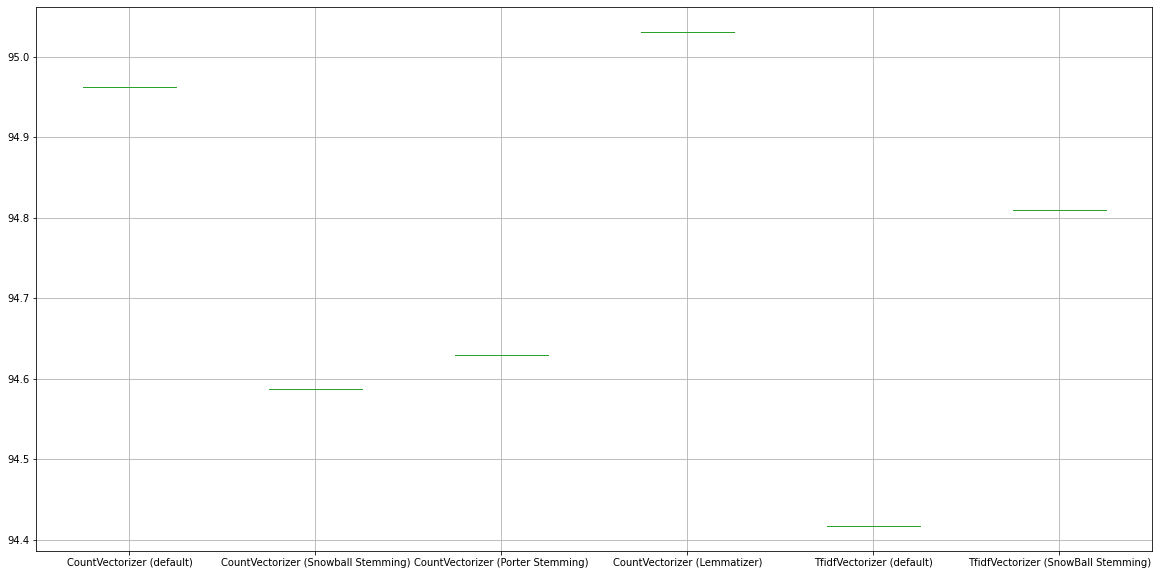

In [116]:
dt_accuracy.boxplot(figsize=[20,10])

### Accuracy mean:

In [117]:
print(dt_accuracy.values.mean())

94.73945902943517


# Random Forest:

## CountVectorizer (default)

              precision    recall  f1-score   support

   True news       0.96      0.99      0.97      6286
   Fake news       0.98      0.96      0.97      5446

    accuracy                           0.97     11732
   macro avg       0.97      0.97      0.97     11732
weighted avg       0.97      0.97      0.97     11732

Classification accuracy 97.3%


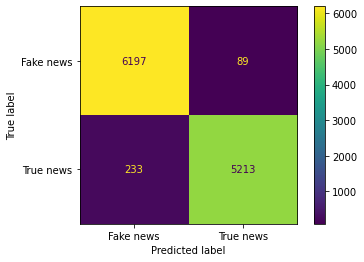

In [118]:
RF = RandomForestClassifier(n_estimators=100, n_jobs=-1)
RF.fit(X_train_vector_cv, y_train)
y_pred = RF.predict(X_test_vector_cv)

RF_acc = accuracy_score(y_test, y_pred)
# Print results
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

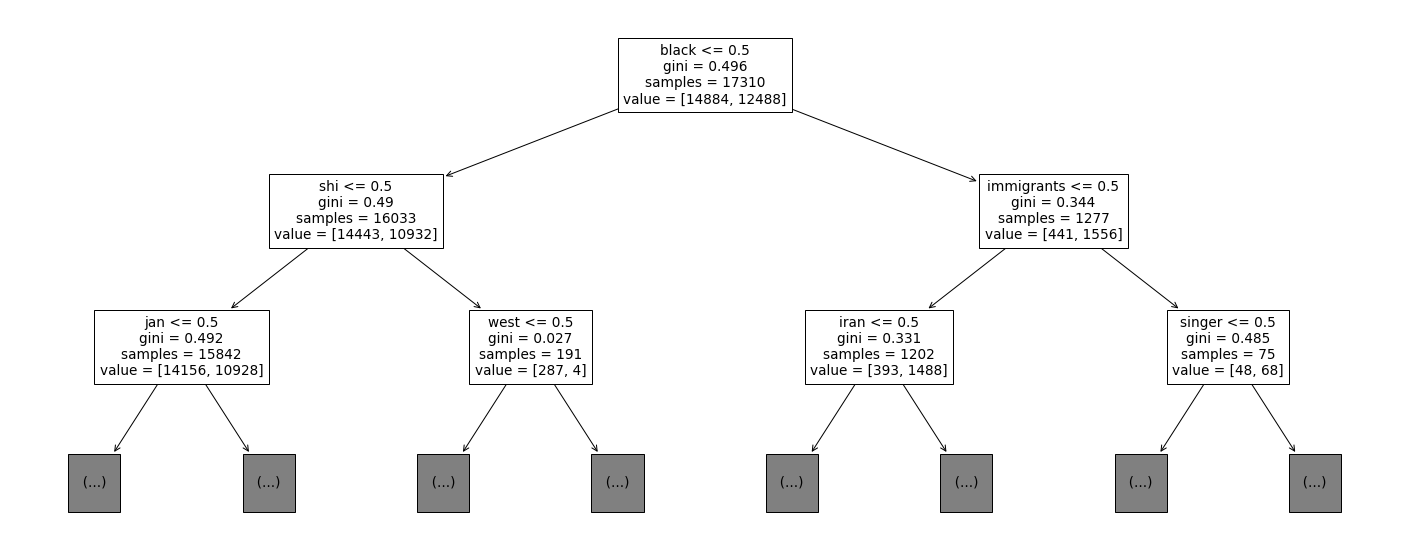

In [119]:
estimator = RF.estimators_[37]
plt.figure(figsize=[25,10])
plot_tree(estimator, max_depth=2, feature_names=l)
plt.show()

## CountVectorizer (Snowball Stemming)

              precision    recall  f1-score   support

   True news       0.96      0.99      0.97      6286
   Fake news       0.98      0.95      0.97      5446

    accuracy                           0.97     11732
   macro avg       0.97      0.97      0.97     11732
weighted avg       0.97      0.97      0.97     11732

Classification accuracy 97.2%


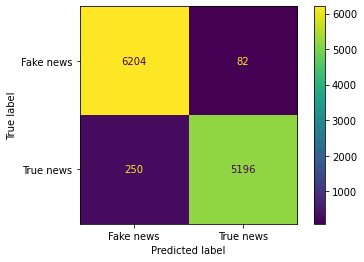

In [120]:
estimators = [('cv', CountVectorizer(analyzer=snowball_analyzer_cv)), ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))]

RF_stem = Pipeline(estimators)
RF_stem.fit(X_train, y_train)
y_pred = RF_stem.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['True news', 'Fake news']))

RF_stem_acc = accuracy_score(y_pred, y_test)
print('Classification accuracy {:.1%}'.format(accuracy_score(y_test, y_pred)))
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = ['Fake news','True news'])
plt.show()

# K-Cross Validation with the best classifiers

In [121]:
# metrics 
scoring = {
    'precision_fake': make_scorer(precision_score, pos_label=1),
    'precision_true': make_scorer(precision_score, pos_label=0),
    'recall_fake': make_scorer(recall_score, pos_label=1),
    'recall_true': make_scorer(recall_score, pos_label=0),
    'fscore_fake': make_scorer(f1_score, pos_label=1),
    'fscore_true': make_scorer(f1_score, pos_label=0),
    'accuracy': make_scorer(accuracy_score)
}


# auxiliary function that prints all metrics
def print_metrics(results):
    metrics = [
        'accuracy', 'precision_fake', 'recall_fake', 'precision_true',
        'recall_true', 'fscore_true', 'fscore_fake'
    ]
    for metric in metrics:
        print(f'{metric:15}', np.round(results["test_" + metric].mean(), 3),
              [np.round(elem, 3) for elem in results["test_" + metric]])
    print()
    print(
        f'{"vocabulary size":15}',
        np.mean([
            len(results['estimator'][i][0].vocabulary_) for i in range(n_folds)
        ]))
    print(f'{"fit_time":15}', np.round(results["fit_time"].mean()))
    print(f'{"score_time":15}', np.round(results["score_time"].mean()))

    
# k cross validation params
n_folds = 10
skf = StratifiedKFold(n_folds)

# Multinomial NB

## CountVectorizer (default)

In [122]:
pipe = Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())])
start = time()
K_mnb = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)
print_metrics(K_mnb)

computing time:
39.12295317649841
accuracy        0.931 [0.936, 0.947, 0.957, 0.896, 0.866, 0.938, 0.958, 0.962, 0.929, 0.92]
precision_fake  0.922 [0.896, 0.908, 0.922, 0.823, 0.78, 0.939, 0.989, 0.987, 0.989, 0.985]
recall_fake     0.938 [0.974, 0.983, 0.99, 0.984, 0.986, 0.925, 0.919, 0.93, 0.854, 0.837]
precision_true  0.95 [0.977, 0.984, 0.991, 0.984, 0.985, 0.938, 0.935, 0.944, 0.889, 0.878]
recall_true     0.925 [0.904, 0.916, 0.929, 0.821, 0.765, 0.95, 0.991, 0.99, 0.992, 0.989]
fscore_true     0.934 [0.939, 0.949, 0.959, 0.895, 0.861, 0.943, 0.962, 0.966, 0.938, 0.93]
fscore_fake     0.926 [0.933, 0.944, 0.955, 0.896, 0.871, 0.932, 0.953, 0.958, 0.916, 0.905]

vocabulary size 115839.4
fit_time        20.0
score_time      2.0


## CountVectorizer (Snowball Stemming)

In [123]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=snowball_analyzer_cv)), ('clf', MultinomialNB())])
start = time()
K_mnb_stem = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)
print_metrics(K_mnb_stem)

computing time:
435.44464015960693
accuracy        0.922 [0.924, 0.933, 0.949, 0.874, 0.843, 0.925, 0.957, 0.961, 0.93, 0.921]
precision_fake  0.908 [0.879, 0.89, 0.907, 0.791, 0.75, 0.921, 0.984, 0.984, 0.987, 0.983]
recall_fake     0.937 [0.968, 0.975, 0.991, 0.986, 0.986, 0.915, 0.92, 0.929, 0.858, 0.842]
precision_true  0.949 [0.97, 0.977, 0.992, 0.985, 0.984, 0.929, 0.936, 0.943, 0.892, 0.881]
recall_true     0.909 [0.888, 0.898, 0.914, 0.78, 0.722, 0.934, 0.988, 0.987, 0.991, 0.988]
fscore_true     0.924 [0.927, 0.936, 0.951, 0.871, 0.833, 0.931, 0.961, 0.964, 0.939, 0.931]
fscore_fake     0.918 [0.921, 0.93, 0.947, 0.878, 0.852, 0.918, 0.951, 0.956, 0.918, 0.907]

vocabulary size 90449.1
fit_time        247.0
score_time      27.0


### Testing Null Hypothesis

In [124]:
metrics_mnb = pd.DataFrame({'K_mnb':K_mnb['test_accuracy'],'K_mnb_stem': K_mnb_stem['test_accuracy']})
wilcoxon(metrics_mnb.K_mnb,metrics_mnb.K_mnb_stem)

WilcoxonResult(statistic=4.0, pvalue=0.013671875)

We can assert that the two classifier are indipendent with a confidence level of 5%, alpha = 0.05

## Comparison

Plot of hist and boxplot to represent the accuracy distribution through the ten splitting of training and test set of the two classifier

array([[<AxesSubplot:title={'center':'K_mnb'}>,
        <AxesSubplot:title={'center':'K_mnb_stem'}>]], dtype=object)

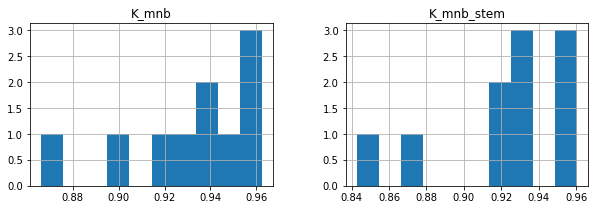

In [125]:
metrics_mnb.hist(layout = (1,2),figsize = (10,3))

<AxesSubplot:>

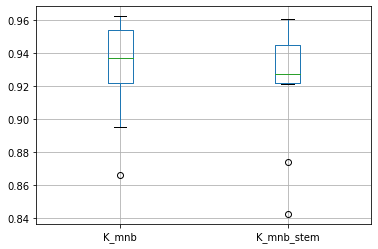

In [126]:
metrics_mnb.boxplot()

# Support Vector:

## TfidfVectorizer (default)

In [127]:
pipe = Pipeline([('vect', TfidfVectorizer()), ('clf', LinearSVC())])
start = time()
K_SVC = cross_validate(pipe,
                           df['body'].values,
                           df['fake'].values,
                           scoring=scoring,
                           return_estimator=True,
                           cv=skf,
                           n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)
print_metrics(K_SVC)

computing time:
36.14479994773865
accuracy        0.985 [0.994, 0.988, 0.995, 0.986, 0.979, 0.979, 0.982, 0.987, 0.976, 0.983]
precision_fake  0.987 [0.989, 0.979, 0.99, 0.975, 0.959, 0.991, 0.998, 0.997, 0.994, 0.995]
recall_fake     0.981 [0.997, 0.996, 0.999, 0.995, 0.996, 0.963, 0.962, 0.976, 0.953, 0.968]
precision_true  0.984 [0.998, 0.997, 0.999, 0.996, 0.997, 0.97, 0.969, 0.98, 0.961, 0.974]
recall_true     0.989 [0.991, 0.982, 0.992, 0.979, 0.964, 0.992, 0.999, 0.997, 0.995, 0.996]
fscore_true     0.986 [0.994, 0.989, 0.995, 0.987, 0.98, 0.981, 0.983, 0.989, 0.978, 0.985]
fscore_fake     0.983 [0.993, 0.987, 0.994, 0.985, 0.977, 0.977, 0.98, 0.986, 0.973, 0.982]

vocabulary size 115839.4
fit_time        19.0
score_time      2.0


## TfidfVectorizer (Snowball Stemming)

In [128]:
pipe = Pipeline([('vect', TfidfVectorizer(analyzer=snowball_analyzer_tfidf)), ('clf', LinearSVC())])
start = time()
K_SVC_stem = cross_validate(pipe,
                           df['body'].values,
                           df['fake'].values,
                           scoring=scoring,
                           return_estimator=True,
                           cv=skf,
                           n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)
print_metrics(K_SVC_stem)

computing time:
431.7197780609131
accuracy        0.982 [0.99, 0.987, 0.992, 0.98, 0.976, 0.973, 0.978, 0.986, 0.976, 0.978]
precision_fake  0.983 [0.984, 0.978, 0.985, 0.963, 0.953, 0.989, 0.994, 0.995, 0.995, 0.991]
recall_fake     0.977 [0.994, 0.996, 0.998, 0.994, 0.997, 0.951, 0.958, 0.974, 0.953, 0.96]
precision_true  0.981 [0.995, 0.996, 0.998, 0.995, 0.997, 0.96, 0.965, 0.978, 0.962, 0.967]
recall_true     0.985 [0.986, 0.981, 0.987, 0.967, 0.958, 0.991, 0.995, 0.996, 0.996, 0.993]
fscore_true     0.983 [0.991, 0.988, 0.992, 0.981, 0.977, 0.975, 0.98, 0.987, 0.978, 0.98]
fscore_fake     0.98 [0.989, 0.986, 0.991, 0.978, 0.974, 0.97, 0.976, 0.984, 0.973, 0.975]

vocabulary size 90449.1
fit_time        247.0
score_time      25.0


### Testing Null Hypothesis

In [129]:
metrics_SVC = pd.DataFrame({'K_SVC':K_SVC['test_accuracy'],'K_SVC_stem': K_SVC_stem['test_accuracy']})
wilcoxon(metrics_SVC.K_SVC,metrics_SVC.K_SVC_stem)

WilcoxonResult(statistic=1.0, pvalue=0.00390625)

We can assert that the two classifier are indipendent with a confidence level of 5%, alpha = 0.05

## Comparison

Plot of hist and boxplot to represent the accuracy distribution through the ten splitting of training and test set of the two classifier

array([[<AxesSubplot:title={'center':'K_SVC'}>,
        <AxesSubplot:title={'center':'K_SVC_stem'}>]], dtype=object)

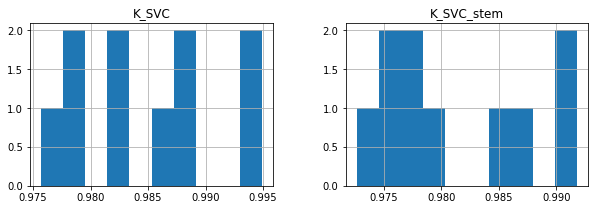

In [130]:
metrics_SVC.hist(layout = (1,2),figsize = (10,3))

<AxesSubplot:>

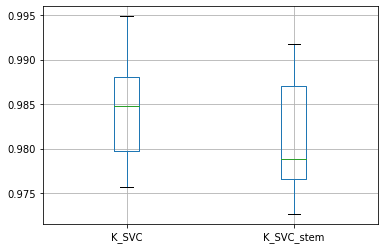

In [131]:
metrics_SVC.boxplot()

# Logistic Regression:

## CountVectorizer (default)

In [166]:
pipe = Pipeline([('vect', CountVectorizer()), ('clf', LogisticRegression(max_iter=10000))])
start = time()
K_LR = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)
print_metrics(K_LR)

computing time:
121.45372295379639
accuracy        0.98 [0.988, 0.988, 0.99, 0.981, 0.975, 0.97, 0.979, 0.984, 0.972, 0.975]
precision_fake  0.983 [0.984, 0.978, 0.983, 0.971, 0.952, 0.984, 0.995, 0.996, 0.99, 0.992]
recall_fake     0.974 [0.991, 0.996, 0.996, 0.988, 0.994, 0.95, 0.959, 0.969, 0.948, 0.952]
precision_true  0.979 [0.992, 0.996, 0.997, 0.989, 0.995, 0.959, 0.966, 0.974, 0.958, 0.961]
recall_true     0.985 [0.987, 0.981, 0.985, 0.975, 0.958, 0.987, 0.996, 0.997, 0.992, 0.994]
fscore_true     0.982 [0.989, 0.989, 0.991, 0.982, 0.976, 0.973, 0.981, 0.985, 0.975, 0.977]
fscore_fake     0.978 [0.987, 0.987, 0.989, 0.979, 0.973, 0.967, 0.976, 0.982, 0.969, 0.972]

vocabulary size 115839.4
fit_time        75.0
score_time      2.0


## CountVectorizer (Snowball Stemming)

In [167]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=snowball_analyzer_cv)), ('clf', LogisticRegression(max_iter = 10000))])
start = time()
K_LR_stem = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)
print_metrics(K_LR_stem)

computing time:
454.983323097229
accuracy        0.978 [0.987, 0.988, 0.991, 0.974, 0.97, 0.965, 0.976, 0.982, 0.967, 0.976]
precision_fake  0.979 [0.984, 0.98, 0.985, 0.955, 0.943, 0.982, 0.992, 0.992, 0.987, 0.991]
recall_fake     0.972 [0.988, 0.994, 0.996, 0.99, 0.994, 0.94, 0.956, 0.968, 0.94, 0.957]
precision_true  0.977 [0.99, 0.995, 0.996, 0.991, 0.995, 0.951, 0.964, 0.973, 0.951, 0.965]
recall_true     0.982 [0.986, 0.983, 0.987, 0.96, 0.95, 0.985, 0.993, 0.993, 0.99, 0.992]
fscore_true     0.979 [0.988, 0.989, 0.991, 0.976, 0.972, 0.968, 0.978, 0.983, 0.97, 0.978]
fscore_fake     0.975 [0.986, 0.987, 0.99, 0.972, 0.968, 0.961, 0.974, 0.98, 0.963, 0.974]

vocabulary size 90449.1
fit_time        257.0
score_time      27.0


### Testing Null Hypothesis

In [134]:
metrics_LR = pd.DataFrame({'K_LR':K_LR['test_accuracy'],'K_LR_stem': K_LR_stem['test_accuracy']})
wilcoxon(metrics_LR.K_LR,metrics_LR.K_LR_stem)

WilcoxonResult(statistic=3.0, pvalue=0.009765625)

We can assert that the two classifier are indipendent with a confidence level of 5%, alpha = 0.05

## Comparison

Plot of hist and boxplot to represent the accuracy distribution through the ten splitting of training and test set of the two classifier

array([[<AxesSubplot:title={'center':'K_LR'}>,
        <AxesSubplot:title={'center':'K_LR_stem'}>]], dtype=object)

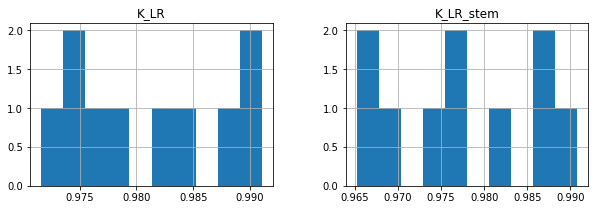

In [135]:
metrics_LR.hist(layout = (1,2),figsize = (10,3))

<AxesSubplot:>

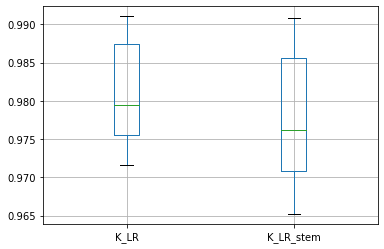

In [136]:
metrics_LR.boxplot()

# Decision Tree:

The first two classifier shown in this section are the best two for the simple hold out validation with the decision tree

## CountVectorizer (default)

In [154]:
pipe = Pipeline([('vect', CountVectorizer()), ('clf', DecisionTreeClassifier())])
start = time()
K_DT = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT)

computing time:
118.44912791252136
accuracy        0.943 [0.958, 0.958, 0.96, 0.942, 0.94, 0.921, 0.94, 0.947, 0.94, 0.928]
precision_fake  0.941 [0.942, 0.931, 0.946, 0.912, 0.923, 0.943, 0.953, 0.956, 0.949, 0.953]
recall_fake     0.936 [0.967, 0.982, 0.968, 0.967, 0.947, 0.881, 0.914, 0.926, 0.918, 0.887]
precision_true  0.947 [0.972, 0.984, 0.973, 0.971, 0.954, 0.904, 0.93, 0.939, 0.933, 0.91]
recall_true     0.95 [0.95, 0.938, 0.953, 0.921, 0.933, 0.955, 0.962, 0.964, 0.958, 0.963]
fscore_true     0.948 [0.961, 0.961, 0.963, 0.945, 0.944, 0.929, 0.945, 0.951, 0.946, 0.936]
fscore_fake     0.938 [0.955, 0.956, 0.957, 0.939, 0.935, 0.911, 0.933, 0.941, 0.934, 0.919]

vocabulary size 115839.4
fit_time        69.0
score_time      2.0


## TfidfVectorizer (Snowball Stemming)

In [145]:
pipe = Pipeline([('vect', TfidfVectorizer(analyzer=snowball_analyzer_tfidf)), ('clf', DecisionTreeClassifier())])
start = time()
K_DT_tfidf = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_tfidf)

computing time:
623.909295797348
accuracy        0.938 [0.96, 0.961, 0.959, 0.936, 0.924, 0.915, 0.939, 0.939, 0.925, 0.919]
precision_fake  0.937 [0.94, 0.942, 0.94, 0.909, 0.9, 0.941, 0.953, 0.954, 0.95, 0.941]
recall_fake     0.927 [0.975, 0.975, 0.973, 0.955, 0.938, 0.868, 0.912, 0.911, 0.884, 0.878]
precision_true  0.94 [0.978, 0.978, 0.977, 0.96, 0.946, 0.895, 0.928, 0.927, 0.907, 0.902]
recall_true     0.947 [0.948, 0.95, 0.947, 0.919, 0.912, 0.954, 0.962, 0.963, 0.96, 0.954]
fscore_true     0.943 [0.963, 0.964, 0.962, 0.939, 0.929, 0.924, 0.945, 0.945, 0.933, 0.927]
fscore_fake     0.931 [0.957, 0.958, 0.956, 0.931, 0.919, 0.903, 0.932, 0.932, 0.916, 0.908]

vocabulary size 90449.1
fit_time        370.0
score_time      26.0


### Testing Null Hypothesis

In [158]:
metrics_DT_ = pd.DataFrame({'K_DT': K_DT['test_accuracy'], 'K_DT_tfidf':K_DT_tfidf['test_accuracy'],})
wilcoxon(metrics_DT_.K_DT_tfidf,metrics_DT_.K_DT)

WilcoxonResult(statistic=7.0, pvalue=0.037109375)

We can assert that the two classifier are indipendent with a confidence level of 5%, alpha = 0.05

## Comparison

Plot of hist and boxplot to represent the accuracy distribution through the ten splitting of training and test set of the two classifier

array([[<AxesSubplot:title={'center':'K_DT'}>,
        <AxesSubplot:title={'center':'K_DT_tfidf'}>]], dtype=object)

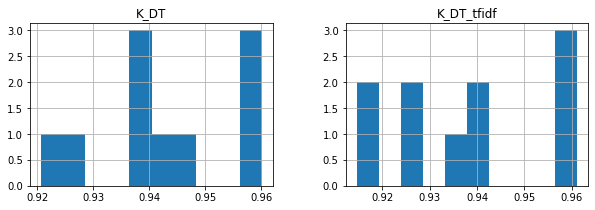

In [159]:
metrics_DT_.hist(layout = (1,2),figsize = (10,3))

<AxesSubplot:>

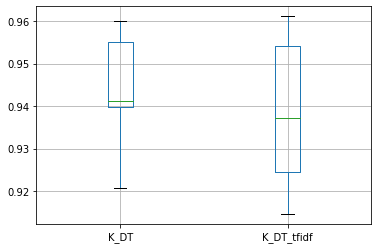

In [160]:
metrics_DT_.boxplot()

# Exploiting Decision Tree to compare accuracy setting lower max_depth

In this section there is K-cross validation performed also with the other classifier tried in the simple hold out validation to compare the accuracy of the complete tree, with the accuracy with a pre pruning.

## CountVectorizer (Snowball Stemming)

### max_depth not specified

In [137]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=snowball_analyzer_cv)), ('clf', DecisionTreeClassifier())])
start = time()
K_DT_snow = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_snow)

computing time:
485.7955868244171
accuracy        0.941 [0.965, 0.961, 0.961, 0.937, 0.94, 0.91, 0.948, 0.95, 0.93, 0.909]
precision_fake  0.941 [0.951, 0.933, 0.948, 0.916, 0.918, 0.943, 0.963, 0.955, 0.945, 0.937]
recall_fake     0.93 [0.974, 0.985, 0.966, 0.95, 0.954, 0.856, 0.921, 0.935, 0.9, 0.859]
precision_true  0.943 [0.978, 0.987, 0.971, 0.957, 0.96, 0.887, 0.936, 0.946, 0.919, 0.889]
recall_true     0.95 [0.958, 0.94, 0.956, 0.926, 0.928, 0.956, 0.97, 0.963, 0.956, 0.951]
fscore_true     0.946 [0.968, 0.963, 0.963, 0.941, 0.944, 0.92, 0.953, 0.954, 0.937, 0.919]
fscore_fake     0.935 [0.962, 0.958, 0.957, 0.933, 0.936, 0.897, 0.942, 0.945, 0.922, 0.897]

vocabulary size 90449.1
fit_time        276.0
score_time      26.0


### max_depth = 15

In [138]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=snowball_analyzer_cv)), ('clf', DecisionTreeClassifier(max_depth=15))])
start = time()
K_DT_snow_15 = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_snow_15)

computing time:
441.1314322948456
accuracy        0.941 [0.974, 0.965, 0.966, 0.948, 0.942, 0.913, 0.931, 0.929, 0.932, 0.913]
precision_fake  0.952 [0.965, 0.948, 0.959, 0.932, 0.936, 0.954, 0.966, 0.963, 0.948, 0.953]
recall_fake     0.918 [0.978, 0.979, 0.966, 0.956, 0.938, 0.851, 0.88, 0.879, 0.901, 0.851]
precision_true  0.934 [0.981, 0.982, 0.972, 0.962, 0.948, 0.885, 0.906, 0.905, 0.92, 0.885]
recall_true     0.961 [0.97, 0.954, 0.965, 0.941, 0.946, 0.965, 0.974, 0.971, 0.958, 0.965]
fscore_true     0.947 [0.976, 0.968, 0.968, 0.952, 0.947, 0.923, 0.938, 0.937, 0.939, 0.923]
fscore_fake     0.934 [0.971, 0.963, 0.963, 0.944, 0.937, 0.899, 0.921, 0.919, 0.924, 0.899]

vocabulary size 90449.1
fit_time        250.0
score_time      26.0


### max_depth = 10

In [139]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=snowball_analyzer_cv)), ('clf', DecisionTreeClassifier(max_depth=10))])
start = time()
K_DT_snow_10 = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_snow_10)

computing time:
440.19111490249634
accuracy        0.934 [0.968, 0.959, 0.958, 0.94, 0.939, 0.889, 0.923, 0.923, 0.92, 0.918]
precision_fake  0.946 [0.958, 0.94, 0.944, 0.926, 0.935, 0.936, 0.965, 0.961, 0.951, 0.942]
recall_fake     0.908 [0.972, 0.972, 0.966, 0.945, 0.93, 0.813, 0.863, 0.866, 0.872, 0.875]
precision_true  0.926 [0.976, 0.976, 0.971, 0.953, 0.941, 0.858, 0.894, 0.895, 0.899, 0.901]
recall_true     0.956 [0.964, 0.948, 0.951, 0.936, 0.946, 0.953, 0.974, 0.97, 0.962, 0.955]
fscore_true     0.94 [0.97, 0.961, 0.961, 0.945, 0.944, 0.903, 0.932, 0.931, 0.929, 0.927]
fscore_fake     0.925 [0.965, 0.956, 0.955, 0.936, 0.933, 0.87, 0.911, 0.911, 0.909, 0.908]

vocabulary size 90449.1
fit_time        252.0
score_time      26.0


### max_depth = 5

In [140]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=snowball_analyzer_cv)), ('clf', DecisionTreeClassifier(max_depth=5))])
start = time()
K_DT_snow_5 = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_snow_5)

computing time:
417.4135138988495
accuracy        0.906 [0.94, 0.937, 0.938, 0.903, 0.909, 0.849, 0.895, 0.9, 0.896, 0.892]
precision_fake  0.904 [0.919, 0.913, 0.928, 0.883, 0.912, 0.909, 0.896, 0.894, 0.877, 0.906]
recall_fake     0.889 [0.953, 0.953, 0.937, 0.91, 0.887, 0.745, 0.871, 0.887, 0.899, 0.853]
precision_true  0.91 [0.959, 0.958, 0.946, 0.922, 0.906, 0.813, 0.893, 0.905, 0.913, 0.881]
recall_true     0.92 [0.929, 0.924, 0.938, 0.898, 0.928, 0.937, 0.915, 0.911, 0.893, 0.925]
fscore_true     0.914 [0.944, 0.941, 0.942, 0.91, 0.917, 0.871, 0.904, 0.908, 0.903, 0.903]
fscore_fake     0.895 [0.936, 0.932, 0.932, 0.896, 0.899, 0.819, 0.883, 0.89, 0.888, 0.879]

vocabulary size 90449.1
fit_time        236.0
score_time      26.0


## CountVectorizer (Lemmatizer)

### max_depth not specified

In [141]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=lemmatizer_analyzer_cv)), ('clf', DecisionTreeClassifier())])
start = time()
K_DT_lemm = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_lemm)

computing time:
213.93304085731506
accuracy        0.941 [0.962, 0.959, 0.962, 0.941, 0.933, 0.917, 0.938, 0.947, 0.935, 0.913]
precision_fake  0.939 [0.949, 0.935, 0.954, 0.916, 0.903, 0.952, 0.95, 0.95, 0.941, 0.94]
recall_fake     0.931 [0.968, 0.978, 0.965, 0.959, 0.956, 0.862, 0.913, 0.932, 0.914, 0.865]
precision_true  0.944 [0.973, 0.98, 0.97, 0.964, 0.961, 0.892, 0.929, 0.944, 0.929, 0.894]
recall_true     0.949 [0.956, 0.943, 0.96, 0.925, 0.914, 0.964, 0.959, 0.959, 0.952, 0.954]
fscore_true     0.946 [0.964, 0.961, 0.965, 0.944, 0.937, 0.926, 0.944, 0.951, 0.94, 0.923]
fscore_fake     0.935 [0.959, 0.956, 0.959, 0.937, 0.929, 0.905, 0.931, 0.941, 0.927, 0.901]

vocabulary size 107591.0
fit_time        123.0
score_time      8.0


### max_depth = 15

In [142]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=lemmatizer_analyzer_cv)), ('clf', DecisionTreeClassifier(max_depth = 15))])
start = time()
K_DT_lemm_15 = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_lemm_15)

computing time:
167.99400877952576
accuracy        0.94 [0.97, 0.963, 0.965, 0.948, 0.94, 0.909, 0.93, 0.929, 0.928, 0.916]
precision_fake  0.952 [0.961, 0.946, 0.966, 0.934, 0.934, 0.964, 0.964, 0.958, 0.944, 0.949]
recall_fake     0.915 [0.974, 0.975, 0.957, 0.954, 0.934, 0.832, 0.879, 0.883, 0.896, 0.863]
precision_true  0.932 [0.978, 0.978, 0.964, 0.961, 0.944, 0.873, 0.905, 0.907, 0.915, 0.893]
recall_true     0.961 [0.967, 0.953, 0.971, 0.943, 0.944, 0.974, 0.972, 0.967, 0.955, 0.961]
fscore_true     0.946 [0.972, 0.965, 0.968, 0.952, 0.944, 0.92, 0.937, 0.937, 0.935, 0.925]
fscore_fake     0.932 [0.968, 0.96, 0.961, 0.944, 0.934, 0.893, 0.92, 0.919, 0.919, 0.904]

vocabulary size 107591.0
fit_time        90.0
score_time      9.0


### max_depth = 10

In [143]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=lemmatizer_analyzer_cv)), ('clf', DecisionTreeClassifier(max_depth = 10))])
start = time()
K_DT_lemm_10 = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_lemm_10)

computing time:
145.75486588478088
accuracy        0.936 [0.965, 0.96, 0.967, 0.942, 0.94, 0.903, 0.923, 0.924, 0.924, 0.915]
precision_fake  0.95 [0.956, 0.943, 0.972, 0.925, 0.933, 0.955, 0.963, 0.96, 0.951, 0.945]
recall_fake     0.908 [0.968, 0.972, 0.956, 0.95, 0.936, 0.826, 0.864, 0.869, 0.878, 0.866]
precision_true  0.927 [0.972, 0.975, 0.963, 0.957, 0.946, 0.868, 0.894, 0.897, 0.903, 0.894]
recall_true     0.96 [0.963, 0.95, 0.976, 0.935, 0.943, 0.967, 0.972, 0.97, 0.962, 0.957]
fscore_true     0.943 [0.968, 0.963, 0.97, 0.946, 0.944, 0.915, 0.931, 0.932, 0.932, 0.925]
fscore_fake     0.928 [0.962, 0.957, 0.964, 0.937, 0.934, 0.886, 0.911, 0.912, 0.913, 0.904]

vocabulary size 107591.0
fit_time        81.0
score_time      8.0


### max_depth = 5

In [144]:
pipe = Pipeline([('vect', CountVectorizer(analyzer=lemmatizer_analyzer_cv)), ('clf', DecisionTreeClassifier(max_depth = 5))])
start = time()
K_DT_lemm_5 = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_lemm_5)

computing time:
141.09061121940613
accuracy        0.906 [0.94, 0.937, 0.939, 0.903, 0.91, 0.849, 0.894, 0.901, 0.895, 0.892]
precision_fake  0.904 [0.92, 0.913, 0.93, 0.883, 0.914, 0.919, 0.895, 0.897, 0.865, 0.907]
recall_fake     0.889 [0.953, 0.953, 0.937, 0.908, 0.888, 0.735, 0.871, 0.886, 0.913, 0.85]
precision_true  0.91 [0.959, 0.959, 0.946, 0.921, 0.907, 0.808, 0.893, 0.904, 0.923, 0.88]
recall_true     0.92 [0.93, 0.924, 0.94, 0.898, 0.929, 0.945, 0.914, 0.914, 0.88, 0.926]
fscore_true     0.914 [0.944, 0.941, 0.943, 0.909, 0.918, 0.871, 0.903, 0.909, 0.901, 0.903]
fscore_fake     0.895 [0.936, 0.933, 0.933, 0.895, 0.901, 0.817, 0.883, 0.891, 0.889, 0.878]

vocabulary size 107591.0
fit_time        78.0
score_time      8.0


## CountVectorizer (default)

### max_depth = 15

In [155]:
pipe = Pipeline([('vect', CountVectorizer()), ('clf', DecisionTreeClassifier(max_depth = 15))])
start = time()
K_DT_15 = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_15)

computing time:
53.88461685180664
accuracy        0.948 [0.966, 0.967, 0.968, 0.951, 0.941, 0.917, 0.937, 0.948, 0.947, 0.935]
precision_fake  0.955 [0.954, 0.948, 0.966, 0.935, 0.938, 0.955, 0.962, 0.967, 0.958, 0.965]
recall_fake     0.93 [0.972, 0.982, 0.963, 0.96, 0.932, 0.86, 0.898, 0.918, 0.925, 0.891]
precision_true  0.943 [0.976, 0.984, 0.969, 0.966, 0.943, 0.891, 0.918, 0.933, 0.939, 0.914]
recall_true     0.963 [0.961, 0.955, 0.972, 0.944, 0.948, 0.966, 0.97, 0.974, 0.966, 0.973]
fscore_true     0.953 [0.968, 0.969, 0.97, 0.955, 0.945, 0.927, 0.943, 0.953, 0.952, 0.942]
fscore_fake     0.942 [0.963, 0.965, 0.964, 0.948, 0.935, 0.905, 0.929, 0.942, 0.941, 0.927]

vocabulary size 115839.4
fit_time        30.0
score_time      2.0


### max_depth = 10

In [156]:
pipe = Pipeline([('vect', CountVectorizer()), ('clf', DecisionTreeClassifier(max_depth=10))])
start = time()
K_DT_10 = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_10)

computing time:
46.83003115653992
accuracy        0.945 [0.963, 0.965, 0.965, 0.953, 0.931, 0.913, 0.932, 0.946, 0.949, 0.931]
precision_fake  0.956 [0.952, 0.951, 0.967, 0.946, 0.938, 0.949, 0.958, 0.964, 0.962, 0.974]
recall_fake     0.922 [0.968, 0.974, 0.956, 0.952, 0.909, 0.857, 0.89, 0.917, 0.926, 0.872]
precision_true  0.937 [0.972, 0.977, 0.964, 0.959, 0.925, 0.888, 0.912, 0.933, 0.939, 0.9]
recall_true     0.964 [0.959, 0.958, 0.973, 0.954, 0.949, 0.961, 0.967, 0.971, 0.969, 0.981]
fscore_true     0.95 [0.966, 0.967, 0.968, 0.956, 0.937, 0.923, 0.939, 0.951, 0.954, 0.939]
fscore_fake     0.938 [0.96, 0.962, 0.962, 0.949, 0.923, 0.9, 0.923, 0.94, 0.944, 0.92]

vocabulary size 115839.4
fit_time        26.0
score_time      2.0


### max_depth = 5

In [157]:
pipe = Pipeline([('vect', CountVectorizer()), ('clf', DecisionTreeClassifier(max_depth=5))])
start = time()
K_DT_5 = cross_validate(pipe,
                          df['body'].values,
                          df['fake'].values,
                          scoring=scoring,
                          return_estimator=True,
                          cv=skf,
                          n_jobs=-1)  # Number of jobs to run in parallel.
# Training the estimator and computing the score are parallelized over the cross-validation splits.
elapsed = time() - start
print('computing time:')
print(elapsed)

print_metrics(K_DT_5)

computing time:
38.4451789855957
accuracy        0.91 [0.937, 0.939, 0.945, 0.92, 0.886, 0.882, 0.901, 0.902, 0.904, 0.886]
precision_fake  0.94 [0.938, 0.94, 0.964, 0.939, 0.942, 0.925, 0.94, 0.949, 0.915, 0.947]
recall_fake     0.859 [0.923, 0.926, 0.915, 0.882, 0.801, 0.807, 0.837, 0.831, 0.873, 0.796]
precision_true  0.89 [0.936, 0.938, 0.931, 0.905, 0.851, 0.853, 0.874, 0.871, 0.896, 0.848]
recall_true     0.953 [0.948, 0.95, 0.971, 0.952, 0.958, 0.945, 0.955, 0.962, 0.931, 0.962]
fscore_true     0.92 [0.942, 0.944, 0.951, 0.928, 0.901, 0.897, 0.912, 0.914, 0.913, 0.902]
fscore_fake     0.897 [0.93, 0.933, 0.939, 0.91, 0.866, 0.862, 0.885, 0.886, 0.893, 0.865]

vocabulary size 115839.4
fit_time        20.0
score_time      2.0
